In [1]:
import pandas as pd
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize
import spacy
from ast import literal_eval
import folium
import re


df1 = pd.read_csv('April 16 - June 12, 2021 T42 Screening Form Submissions.csv')
df2 = pd.read_csv('June 15 - August 11, 2021 T42 Screening Form Submissions.csv')
df3 = pd.read_csv("August 2021 T42 Screening.csv")

df = pd.concat([df1, df2, df3], axis=0)

In [2]:
df['Language'].value_counts()

Language
Español     1489
Kekchi        23
Quiche        15
Chuj           7
Mam            6
English        5
Kanjobal       4
Soltero        4
Kreyol         3
Mixteco        2
Otro           1
Qeqchi         1
Name: count, dtype: int64

In [3]:
non_indigenous_languages = ["Español", "English","Kreyol"]

# Count the number of rows that don't have the specific value in the column
count = df["Language"].replace(non_indigenous_languages, None).value_counts().sum()
print(f"Percentage of Indigenous Language Speaking Parties - \033[1m{(count/len(df['Language'].dropna())):.2%}\033[0m")


Percentage of Indigenous Language Speaking Parties - 4.04%


In [4]:
df["Prior Deportation"].value_counts()

Prior Deportation
No       545
No sé     27
Si        22
Name: count, dtype: int64

In [5]:
replace_values = {"No he entrado a los Estados Unidos durante el último año.":"0",
                 "Más de 5": "5"
                 }
df["# Returned to MX"] = df["# Returned to MX"].replace(replace_values)
df["# Returned to MX"] = pd.to_numeric(df["# Returned to MX"], errors='coerce')
df["# Returned to MX"] = df["# Returned to MX"].fillna(-1).astype(int)

df["# Returned to MX"].value_counts()

# Returned to MX
 1     480
-1     461
 0     353
 2     168
 3      49
 4      30
 5      12
 6       5
 18      4
 11      2
Name: count, dtype: int64

1097
744
0.6782133090246126


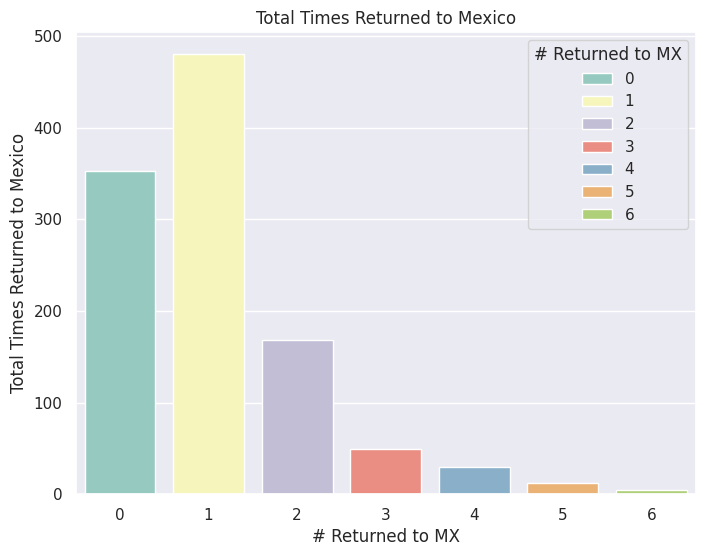

In [6]:
sns.set(style="darkgrid")
plt.figure(figsize=(8, 6))
filtered_df = df[df['# Returned to MX'] != -1]
filtered_df = filtered_df[filtered_df['# Returned to MX'] != 11]
filtered_df = filtered_df[filtered_df['# Returned to MX'] != 18]
total = (filtered_df['# Returned to MX'].count())
number_removed = filtered_df[filtered_df['# Returned to MX'] != 0]['# Returned to MX'].count()
print(total)
print(number_removed)
print(number_removed/total)
sns.countplot(x='# Returned to MX', data=filtered_df, palette="Set3", hue="# Returned to MX")

# Customize the plot (optional)
plt.title('Total Times Returned to Mexico')
plt.xlabel('# Returned to MX')
plt.ylabel('Total Times Returned to Mexico')

# Show the plot
plt.show()

In [7]:
df["Hair Color"].value_counts()

Hair Color
Negro          1252
Marrón          166
Rubio            84
Desconocido      19
Rojo              8
Gris              7
Calvo             5
Arenoso           5
Blanco            4
Naranja           3
Verde             2
Name: count, dtype: int64

In [8]:
df["Only US Entry Date"].isna().sum()

1283

In [9]:
df["First US Entry Date"].isna().sum()

1401

In [10]:
df["Mexico Entry Date"].isna().sum()

822

In [11]:
df["Date of Leaving Mexico"] = df['First US Entry Date'].fillna(df['Only US Entry Date'])
df["Date of Leaving Mexico"].isna().sum()

1120

In [12]:
df['Date of Leaving Mexico'] = pd.to_datetime(df['Date of Leaving Mexico'], format='%d/%m/%Y')
df['Mexico Entry Date'] = pd.to_datetime(df['Mexico Entry Date'], format='%d/%m/%Y')
df["travel_time"] = df['Date of Leaving Mexico'] - df['Mexico Entry Date']

print(f"Average time through Mexico from date entered to day of first attempt at crossing: \033[1m {df['travel_time'].mean().days} days \033[0m")


Average time through Mexico from date entered to day of first attempt at crossing:  77 days 


In [13]:
df['Displacement Date (left home country)']

0     18/3/2021
1     18/3/2021
2      6/3/2021
3      6/3/2021
4      6/3/2021
        ...    
51     3/2/2007
52     8/8/2013
53    20/1/2021
54    18/5/2020
55    18/5/2020
Name: Displacement Date (left home country), Length: 1564, dtype: object

In [47]:
import numpy as np
# Columns containing the word "Date"
date_columns = [col for col in df.columns if ('Date' in col and "US" not in col)]
objects_to_remove = set(('Date', 'Displacement Date (left home country)', 'Date of HIAS Referral '))
date_columns = [x for x in date_columns if x not in objects_to_remove]
print(date_columns)

for column in date_columns:
    df[column] = pd.to_datetime(df[column], format='mixed', dayfirst=True, errors='coerce')

def sort_and_remove_nan(row):
    sorted_values = sorted(row.dropna())
    if len(sorted_values)>1:
        return sorted_values
    else:
        return np.nan

# Apply the function to each row to create the new column
df['All Dates'] = df[date_columns].apply(sort_and_remove_nan, axis=1)

def calc_time(date_list):
    if type(date_list) is float:
        return date_list
    if len(date_list) <=1:
        return None
    return (date_list[-1] - date_list[0]).days
        

print(df['All Dates'].isna().sum())    

df['travel_time'] = df['All Dates'].apply(calc_time)

print(df['travel_time'].median())

['Mexico Entry Date', 'Guatemala Entry Date', 'Guatemala Exit Date ', 'El Salvador Entry Date', 'El Salvador Exit Date ', 'Honduras Entry Date', 'Honduras Exit Date', 'Nicaragua Entry Date', 'Nicaragua Exit Date', 'Date of Leaving Mexico', 'Total Dates', 'All Dates']
1059
20.0
